In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow_addons as tfa
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from tqdm import tqdm

from lib.utils import fix_random_seed, read_json
from src.config import c
from src.data_utils import predictions_to_text_labels
from src.generator import Generator
from src.models import Div, SinCos, YMToDate
from src.services import get_msg_provider, get_wave_provider

In [2]:
fix_random_seed(c["SEED"])

In [3]:
MODEL = "/app/_work/models/B1_nrsw_2/B1_nrsw_2.h5"
TEST_FRAC = 1.0

In [4]:
meta = read_json(MODEL.replace(".h5", ".json"))

In [5]:
model = keras.models.load_model(
    MODEL,
    custom_objects={
        "SinCos": SinCos,
        "Div": Div,
        "YMToDate": YMToDate,
    },
)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA Tesla V100-DGXS-32GB, compute capability 7.0


In [6]:
df = pd.read_pickle(c["WORK_DIR"] + "/" + meta["args"]["dataset"])
df = df.sample(frac=TEST_FRAC).reset_index(drop=True)

In [7]:
input_shape = model.get_layer("i_msg").input_shape[0][1:]
wave_p = get_wave_provider(meta["config"])
msg_p = get_msg_provider(
    meta["config"],
    n_mels=input_shape[0],
    time_steps=input_shape[1],
)

/usr/local/lib/python3.8/dist-packages/torchaudio/functional/functional.py:357: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (380) may be set too high. Or, the value for `n_freqs` (1025) may be set too low.
  warnings.warn(


In [8]:
g = Generator(
    df=df,
    shuffle=False,
    augmentation=None,
    rating_as_sw=False,
    rareness_as_sw=False,
    msg_provider=msg_p,
    wave_provider=wave_p,
    msg_as_rgb=(3 == input_shape[-1]),
    geo_coordinates_bins=meta["config"]["GEO_COORDINATES_BINS"],
    batch_size=64,
)

In [9]:
Y_true = []

for y in list(df["_y"]):
    Y_true.append(y)

Y_true = np.array(Y_true, dtype=np.float32)

In [10]:
Y_pred = model.predict(
    x=g,
    use_multiprocessing=True,
    workers=4,
    max_queue_size=4,
    verbose=1,
)

5517/5517 [==============================] - 2064s 371ms/step


In [11]:
Y_true = Y_true[: len(Y_pred)]

In [12]:
l_pred = predictions_to_text_labels(
    Y_pred, meta["labels"], default_label=None, max_labels=1
)
l_true = predictions_to_text_labels(
    Y_true, meta["labels"], default_label=None, max_labels=1
)
cm = confusion_matrix(l_true, l_pred, labels=meta["labels"], normalize="all")

In [13]:
cm = (cm - cm.min()) / cm.max()

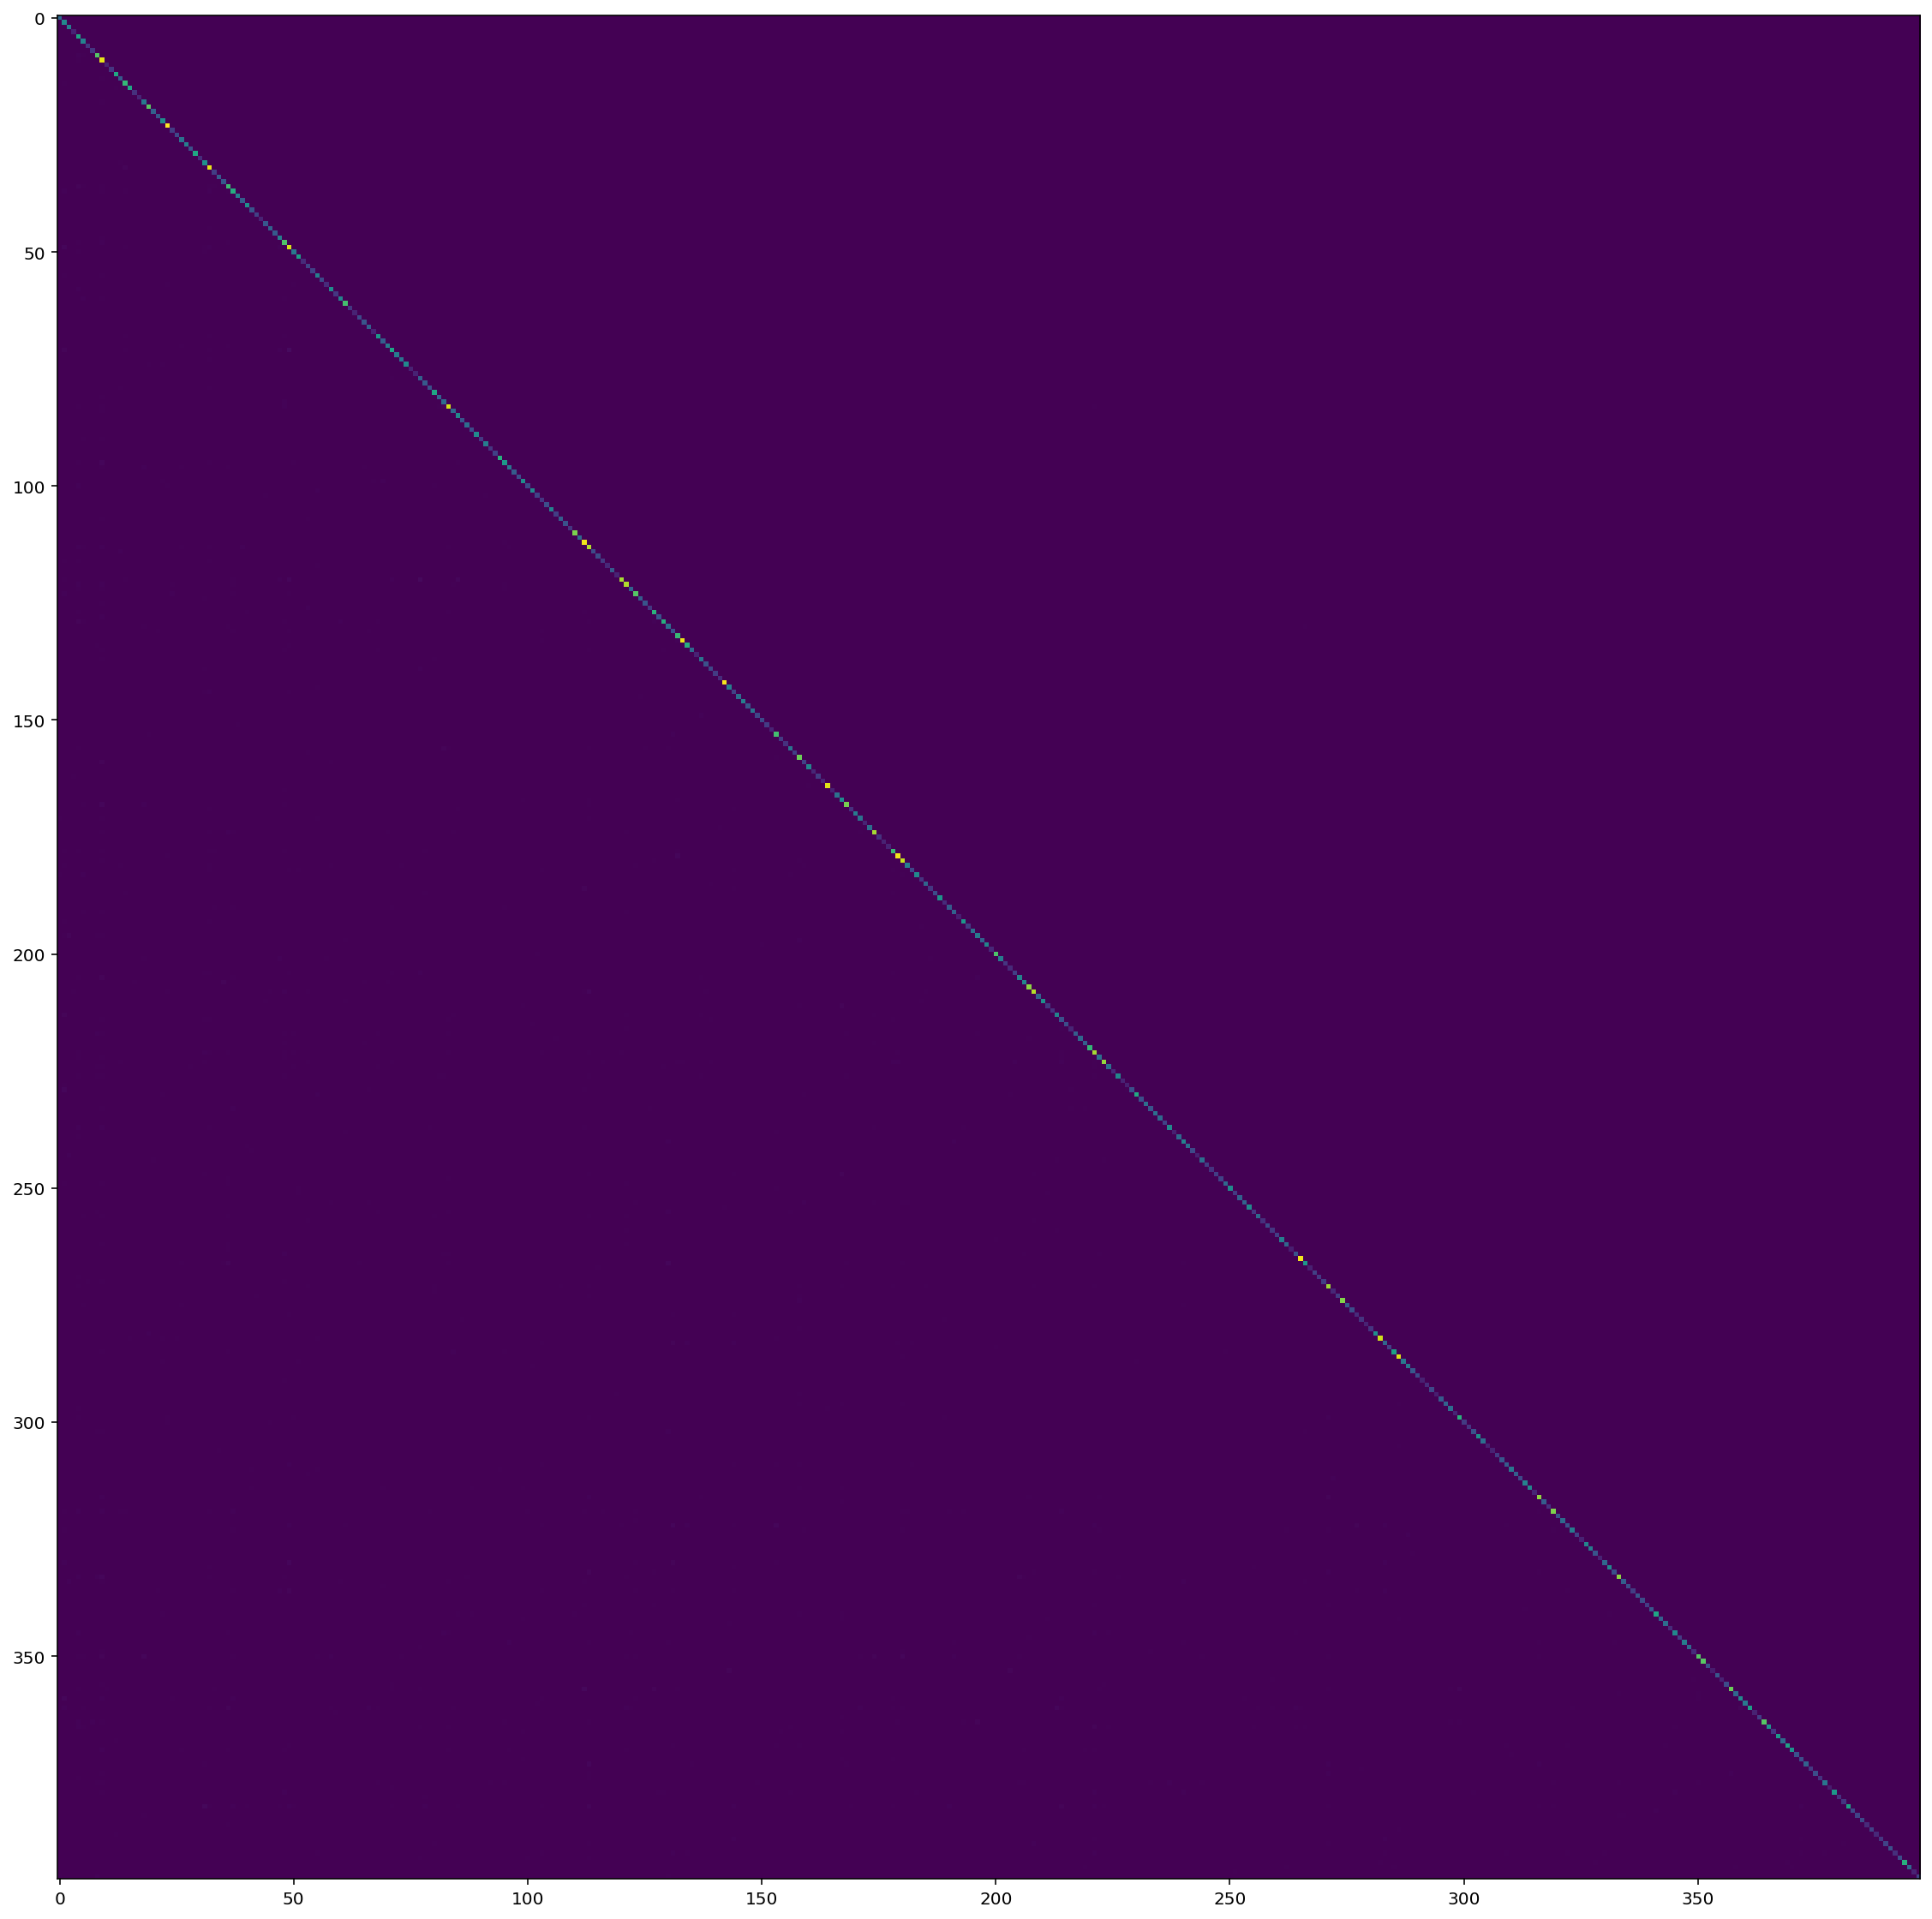

In [14]:
plt.figure(figsize=(20, 20))
plt.imshow(cm)

In [15]:
problem_classes_cm = cm * np.where(np.eye(*cm.shape), 0, 1)

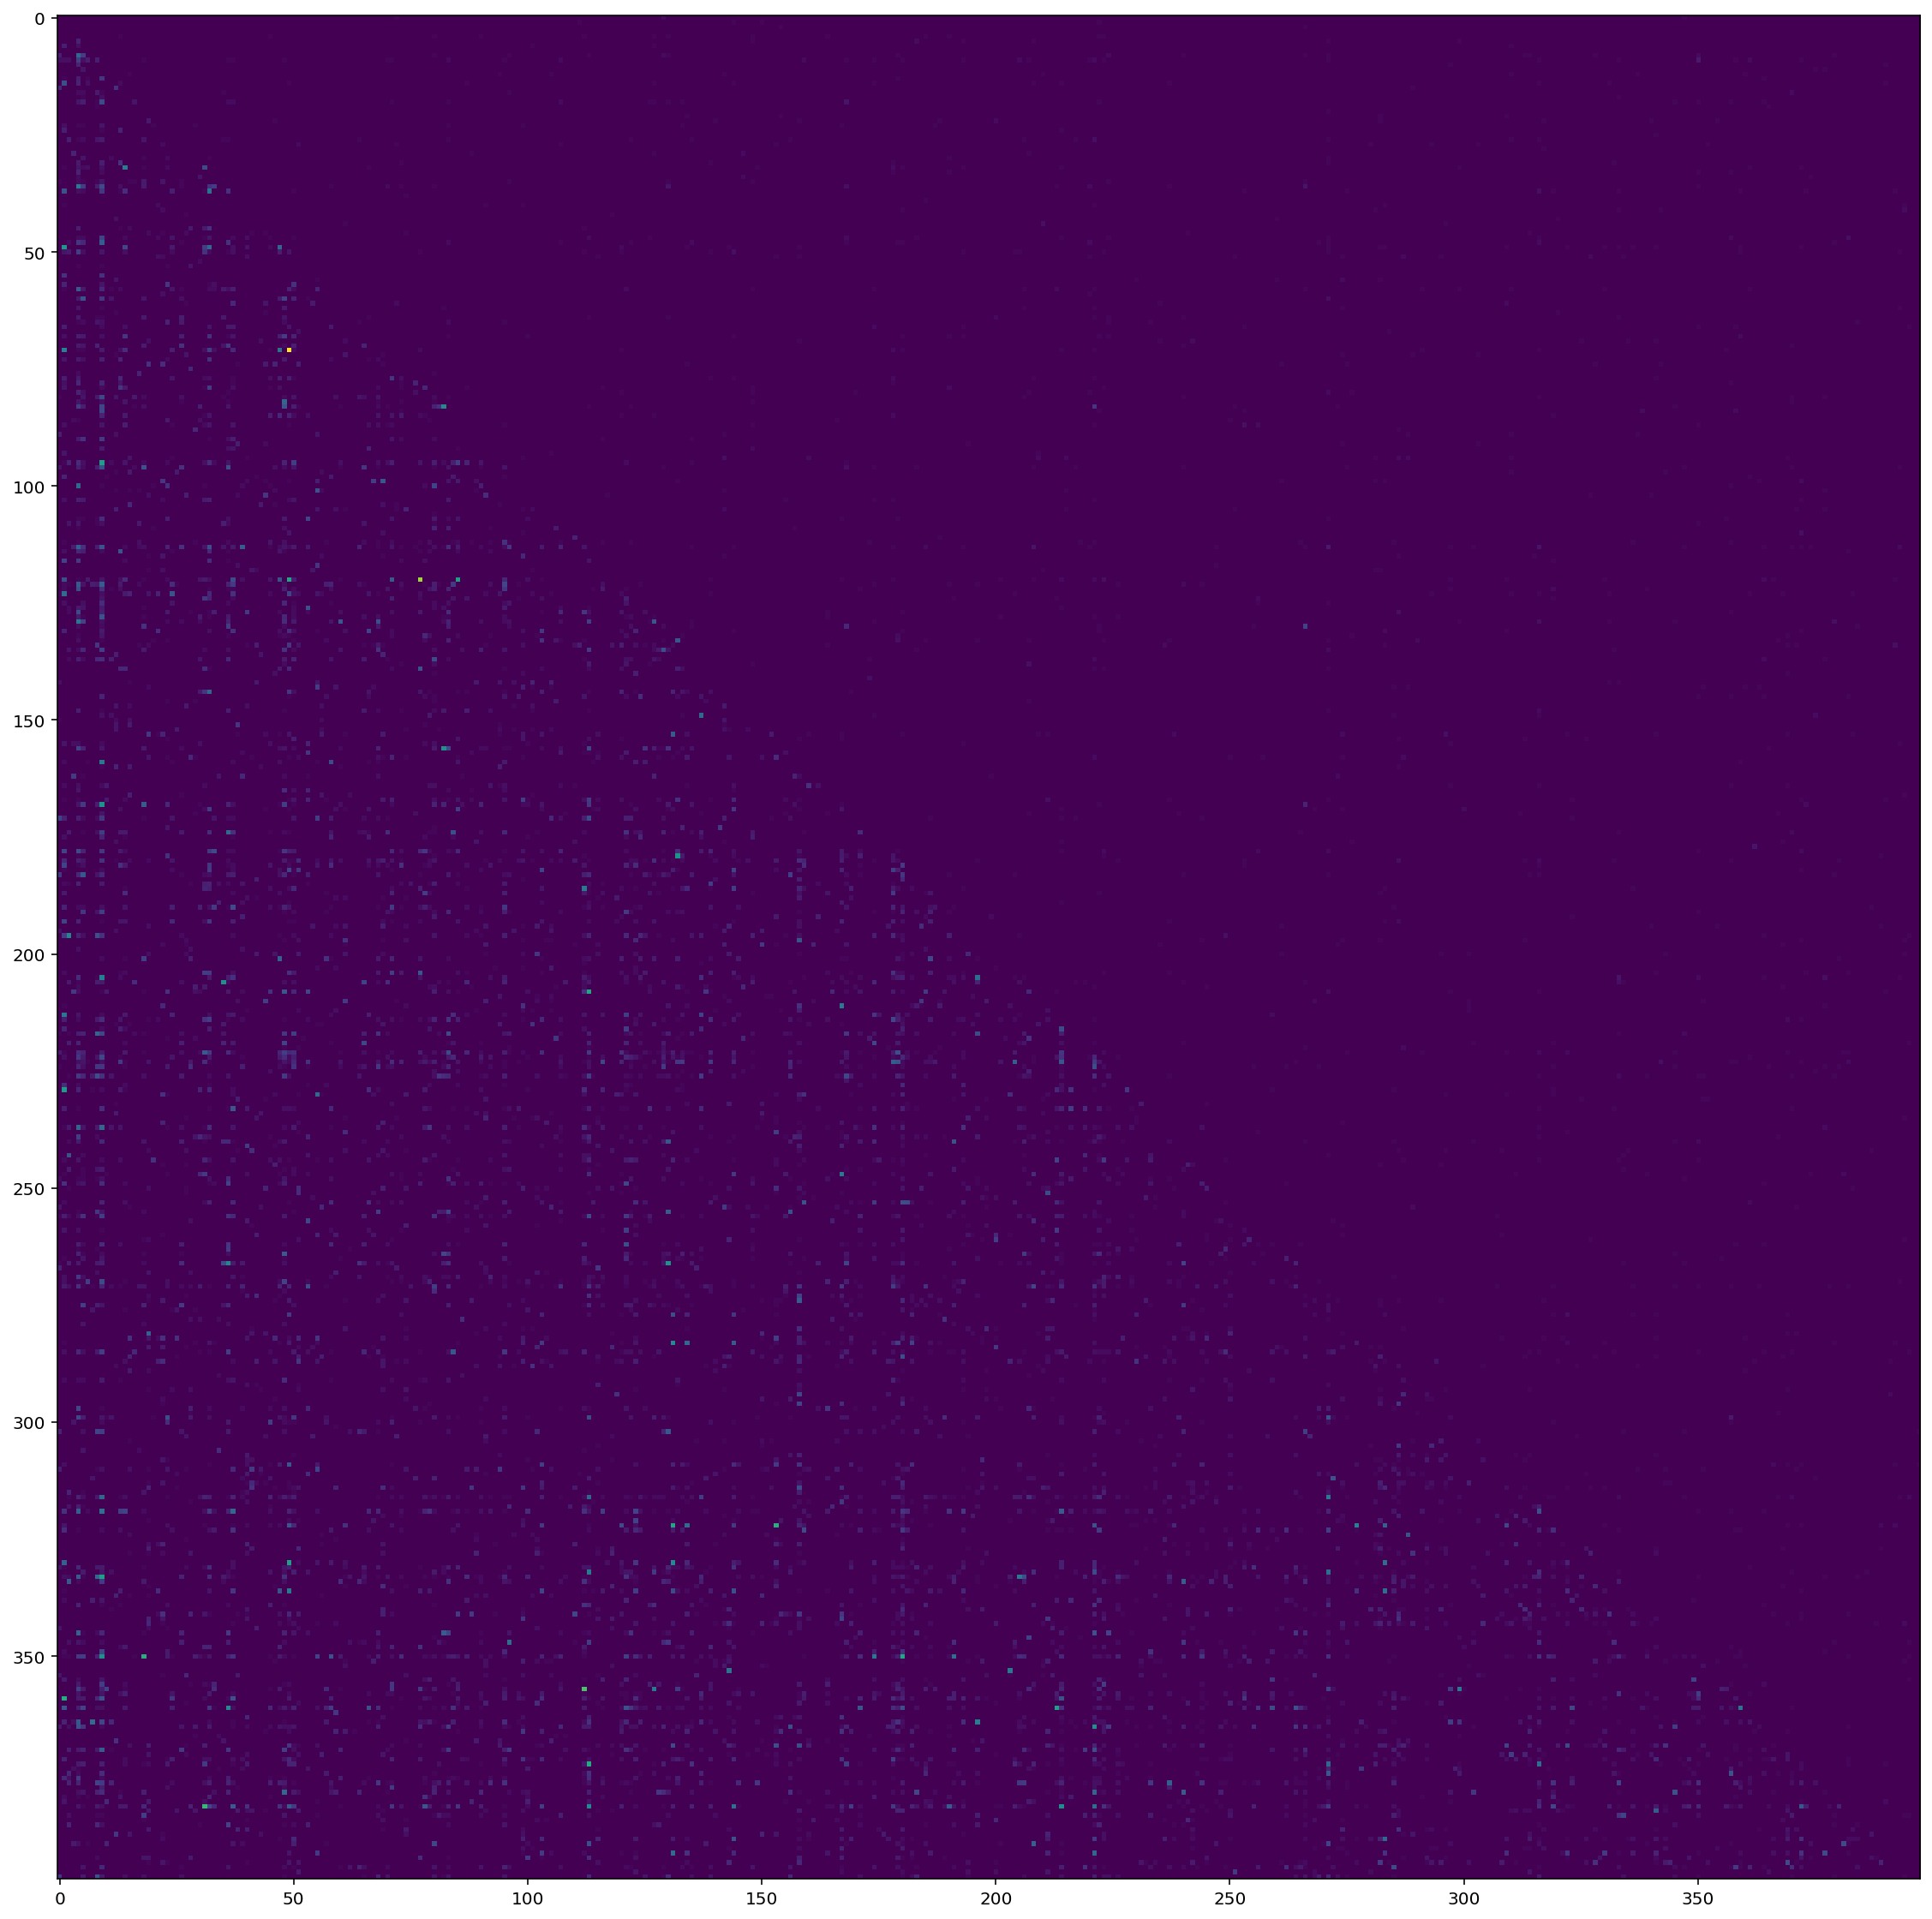

In [16]:
plt.figure(figsize=(20, 20))
plt.imshow(problem_classes_cm)

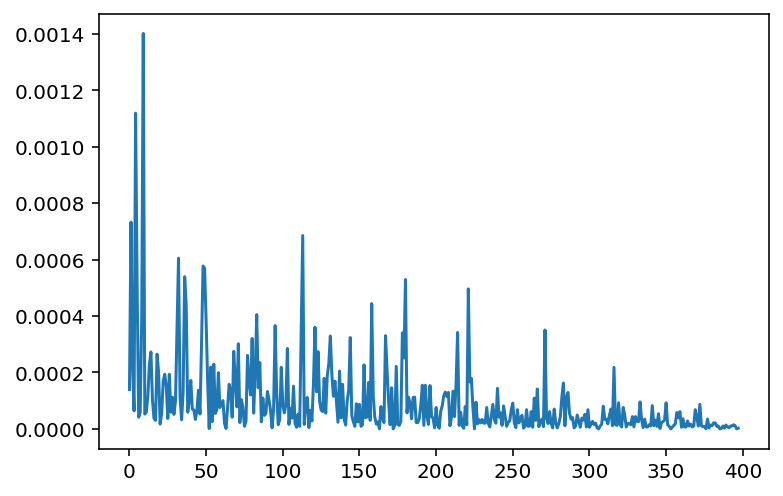

In [17]:
plt.plot(problem_classes_cm.mean(axis=0))

In [18]:
np.save('cm', cm)